In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install phik -q
! pip install --no-deps autoxgb
!pip install optuna
!pip install catboost
from catboost import CatBoostClassifier
from autoxgb import AutoXGB
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
import optuna
import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.decomposition import PCA

In [ ]:
def cross_validate(model, X, y, split = 5):
   skf = StratifiedKFold(n_splits=split, random_state = 17, shuffle=True)
   models = []
   scores = []
   for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        score = f1_score(model.predict(X_val), y_val, average = 'micro')
        scores.append(score)
        models.append(model)
        print(score)
   print(np.mean(scores), np.std(scores))
   return models

def pred_cross(models, X):
  preds = [mode.predict(X) for mode in models]
  res = []
  for i in range(len(preds[0])):
     pr = [pred[i] for pred in preds]
     res.append(int(stats.mode(pr)[0]))
  return res

def pred_proba(models, X):
  res = [model.predict_proba(X) for model in models]
  return np.sum(res, axis=0)

def chi_squared_test(df, input_var, target_var, significance_level=0.05):
    contingency_table = pd.crosstab(df[input_var], df[target_var])
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)

    if p < significance_level:
        print(f'\033[32m{input_var} has a significant relationship with the target variable.\033[0m')
    else:
        print(f'\033[31m{input_var} does not have a significant relationship with the target variable.\033[0m')

for i in cat_var:
    chi_squared_test(train, i, target)

In [ ]:
submit = pd.read_csv('sample_submission.csv')

In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
train = pd.read_csv('train.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1235 non-null   object 
 8   peripheral_pulse       1235 non-null   object 
 9   mucous_membrane        1235 non-null   object 
 10  capillary_refill_time  1235 non-null   object 
 11  pain                   1235 non-null   object 
 12  peristalsis            1235 non-null   object 
 13  abdominal_distention   1235 non-null   object 
 14  nasogastric_tube       1235 non-null   object 
 15  naso

In [ ]:
train.isnull().sum()

id                       0
surgery                  0
age                      0
hospital_number          0
rectal_temp              0
pulse                    0
respiratory_rate         0
temp_of_extremities      0
peripheral_pulse         0
mucous_membrane          0
capillary_refill_time    0
pain                     0
peristalsis              0
abdominal_distention     0
nasogastric_tube         0
nasogastric_reflux       0
nasogastric_reflux_ph    0
rectal_exam_feces        0
abdomen                  0
packed_cell_volume       0
total_protein            0
abdomo_appearance        0
abdomo_protein           0
surgical_lesion          0
lesion_1                 0
lesion_2                 0
lesion_3                 0
cp_data                  0
outcome                  0
dtype: int64

# Catboost Feature Importance

<Axes: >

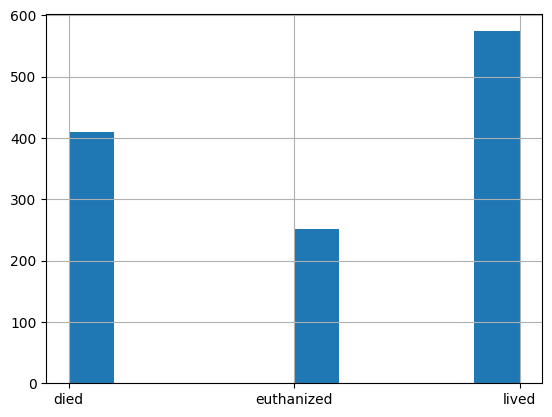

In [ ]:
y.hist()

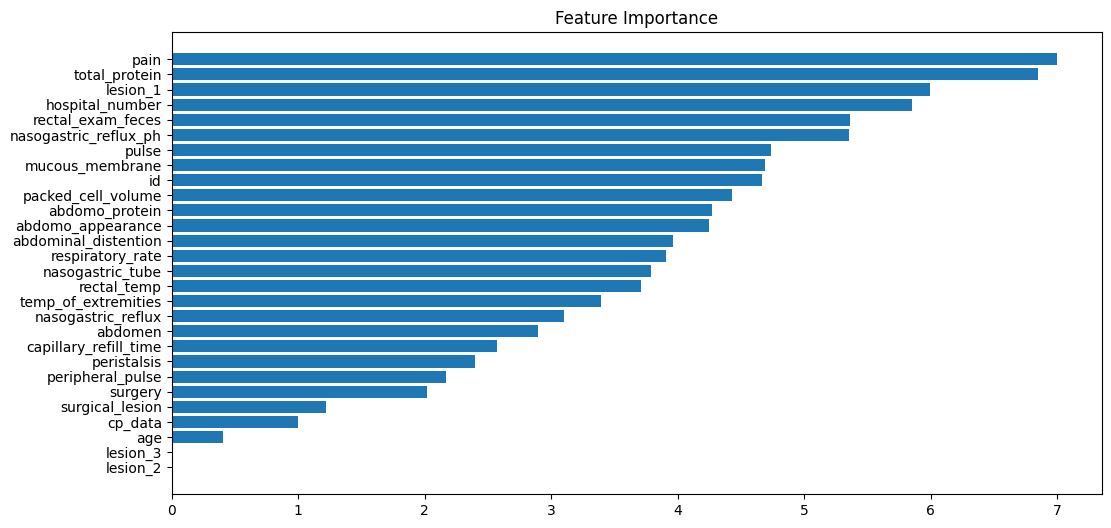

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

In [ ]:
X = train.drop(['lesion_2', 'lesion_2', 'age', 'cp_data', 'outcome'], axis = 1)
cat_col = [x for x in X.columns if X[x].dtype == 'object']
test = test.drop(['lesion_2', 'lesion_2', 'age', 'cp_data'], axis = 1)

In [ ]:
enc = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
X[cat_col] = enc.fit_transform(X[cat_col])

In [ ]:
test[cat_col] = enc.transform(test[cat_col])

In [ ]:
lab = LabelEncoder()

In [ ]:
y = lab.fit_transform(train['outcome'])

In [ ]:
y = pd.DataFrame(y)

# CatBoost validation

In [ ]:
model = cross_validate(CatBoostClassifier(verbose = 0), X, y)

0.7044534412955465
0.6923076923076923
0.6882591093117408
0.7044534412955465
0.6882591093117408
0.6955465587044535 0.0074211752145034015


In [ ]:
pred = pred_cross(model, test)

In [ ]:
pred = lab.inverse_transform(pred)

(array([392.,   0.,   0.,   0.,   0., 318.,   0.,   0.,   0., 114.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

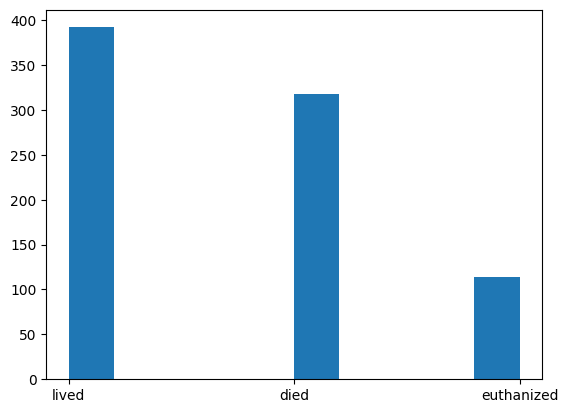

In [ ]:
plt.hist(pred)

In [ ]:
submit['outcome'] = pred

In [ ]:
submit.to_csv('pred.csv', index = False)

# AutoXGB

In [ ]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

X = train.drop(['lesion_2', 'lesion_2', 'age', 'cp_data', 'outcome', 'id'], axis = 1)
cat_col = [x for x in X.columns if X[x].dtype == 'object']
test = test.drop(['lesion_2', 'lesion_2', 'age', 'cp_data', 'id'], axis = 1)
num_col = [x for x in X.columns if X[x].dtype != 'object']

In [ ]:
transform = PCA(n_components = 0.95)

In [ ]:
X['pca'] = transform.fit_transform(X.drop(cat_col, axis = 1))
test['pca'] = transform.transform(test.drop(cat_col, axis = 1))

In [ ]:
X_pca = X.drop(num_col, axis = 1)
test_pca = test.drop(num_col, axis = 1,)

In [ ]:
train_ = pd.concat([pd.DataFrame(X_pca), y], axis = 1)
train_.to_csv('train_.csv')
test_pca.to_csv('test_.csv')

In [ ]:
train_filename="train_.csv"
output="submit"
test_filename="test_.csv"
idx="Id"
targets=["0"]
use_gpu=True
num_folds=5
seed=42
num_trials=50
time_limit=600
categorical_features = cat_col

axgb=AutoXGB(
    train_filename=train_filename,
    output=output,
    test_filename=test_filename,
    idx=idx,
    targets=targets,
    use_gpu=use_gpu,
    num_folds=num_folds,
    num_trials=num_trials,
    time_limit=time_limit
)

axgb.train()

In [ ]:
pred = pd.read_csv('/content/submit/test_predictions.csv')

In [ ]:
pred

,Id,0,1,2
0,0,0.005456,0.059154,0.935390
1,1,0.587193,0.096689,0.316118
2,2,0.109296,0.024817,0.865887
3,3,0.051413,0.785471,0.163116
4,4,0.199829,0.040804,0.759366
...,...,...,...,...
819,819,0.584114,0.300483,0.115403
820,820,0.409795,0.205947,0.384258
821,821,0.842971,0.035456,0.121573
822,822,0.044320,0.020454,0.935226


In [ ]:
res = []
pred = pred[['0', '1', '2']]

In [ ]:
res = []
pred = pred[['0', '1', '2']]
for i in range(len(pred)):
  pr = [pred['0'].iloc[i], pred['1'].iloc[i], pred['2'].iloc[i]]
  res.append(pr.index(max(pr)))

In [ ]:
pred = lab.inverse_transform(res)

In [ ]:
submit['outcome'] = pred

In [ ]:
submit.to_csv('pred_pca.csv', index = False)

# Random Forest Optuna + validation

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)

    param = {
        "max_depth": trial.suggest_int("max_depth", 100, 700, step = 100),
        'criterion' : trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'n_estimators' : trial.suggest_int('n_estimators', 10, 500, step = 50),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 16, step = 3),

    }


    rfr = RandomForestClassifier(**param)

    rfr.fit(train_x, train_y)
    preds = rfr.predict(valid_x)
    accuracy = f1_score(valid_y, preds, average = 'micro')
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=300)

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.7520215633423181
  Params: 
    max_depth: 300
    criterion: entropy
    n_estimators: 210
    min_samples_split: 11


In [ ]:
rfr = cross_validate(RandomForestClassifier(max_depth = 300, criterion = 'entropy', n_estimators = 210,\
                                            min_samples_split = 11), X, y)

<ipython-input-3-14675dc3790b>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


0.7125506072874493


<ipython-input-3-14675dc3790b>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


0.7165991902834008


<ipython-input-3-14675dc3790b>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


0.6923076923076923


<ipython-input-3-14675dc3790b>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


0.6923076923076923


<ipython-input-3-14675dc3790b>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


0.6842105263157895
0.6995951417004049 0.012648177612804287


In [ ]:
train_pred = pred_cross(rfr, X)
train_pred = pd.DataFrame(train_pred)
train_pred.to_csv('rfr_train.csv')

test_pred = pred_cross(rfr, test)
test_pred = lab.inverse_transform(test_pred)
test_pred = pd.DataFrame(test_pred)
test_pred.to_csv('rfr_test.csv')

submit['outcome'] = test_pred
submit.to_csv('rfr.csv', index = False)

# CatBoost + optuna + cross_validation

In [ ]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)

    param = {
        'iterations' : trial.suggest_int("iterations", 100, 1000),
        'learning_rate':trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth':trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg':trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
       'bootstrap_type':trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        'random_strength':trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature':trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type':trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait':trial.suggest_int("od_wait", 10, 50),
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb = CatBoostClassifier(**param, cat_features = [x for x in X.columns if X[x].dtype == 'object'])

    cb.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = cb.predict(valid_x)
    accuracy = f1_score(valid_y, preds, average = 'micro')
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 23
Best trial:
  Value: 0.7412398921832885
  Params: 
    iterations: 715
    learning_rate: 0.0047062999065665976
    depth: 8
    l2_leaf_reg: 3.810242868650054e-05
    bootstrap_type: Bayesian
    random_strength: 2.1222582555976902e-05
    bagging_temperature: 2.708922704223478
    od_type: Iter
    od_wait: 10


In [ ]:
cat = cross_validate(CatBoostClassifier(iterations = 715, learning_rate = 0.0047062999065665976,
    depth = 8, l2_leaf_reg = 3.810242868650054e-05, bootstrap_type = 'Bayesian',
    random_strength = 2.1222582555976902e-05, bagging_temperature = 2.708922704223478,
    od_type = 'Iter', od_wait = 10, cat_features = [x for x in X.columns if X[x].dtype == 'object'], verbose = 0), X, y)

0.7165991902834008
0.7125506072874493
0.6923076923076923
0.7044534412955465
0.6842105263157895
0.7020242914979757 0.012172709618115701


In [ ]:
train_pred = pred_cross(cat, X)
train_pred = pd.DataFrame(train_pred)
train_pred.to_csv('cb_train.csv')

test_pred = pred_cross(cat, test)
test_pred = lab.inverse_transform(test_pred)
test_pred = pd.DataFrame(test_pred)
test_pred.to_csv('cb_test.csv')

submit['outcome'] = test_pred
submit.to_csv('cb.csv', index = False)

# Stacking

In [ ]:
pred = pd.read_csv('/content/xgb_train_pred.csv')
res = []
pred = pred[['0', '1', '2']]
for i in range(len(pred)):
  pr = [pred['0'].iloc[i], pred['1'].iloc[i], pred['2'].iloc[i]]
  res.append(pr.index(max(pr)))

In [ ]:
train = pd.DataFrame()

In [ ]:
train['rfr'] = pd.read_csv('rfr_train.csv')['0']
train['cb'] = pd.read_csv('cb_train.csv')['0']
train['xgb'] = res

In [ ]:
pred = pd.read_csv('/content/xgb_test_predictions.csv')
res = []
pred = pred[['0', '1', '2']]
for i in range(len(pred)):
  pr = [pred['0'].iloc[i], pred['1'].iloc[i], pred['2'].iloc[i]]
  res.append(pr.index(max(pr)))

In [ ]:
test = pd.DataFrame()
test['rfr'] = pd.read_csv('rfr_test.csv')['0']
test['cb'] = lab.transform(pd.read_csv('cb_test.csv')['0'])
test['xgb'] = res

In [ ]:
test

,rfr,cb,xgb
0,2,2,2
1,0,0,0
2,2,2,2
3,1,1,1
4,2,2,2
...,...,...,...
819,0,0,0
820,1,1,2
821,0,0,0
822,2,2,2


In [ ]:
model = cross_validate(RandomForestClassifier(), train, y)

<ipython-input-3-ece8311cbbf7>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-3-ece8311cbbf7>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


0.9473684210526315
0.9230769230769231


<ipython-input-3-ece8311cbbf7>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-3-ece8311cbbf7>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


0.9392712550607287
0.9433198380566802
0.6842105263157895
0.8874493927125506 0.10195357744729619


<ipython-input-3-ece8311cbbf7>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


In [ ]:
pred = pred_cross(model, test)

In [ ]:
submit['outcome'] = lab.inverse_transform(pred)

In [ ]:
submit.to_csv('stacking.csv', index = False)